In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # removal rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([0, 0])  # each age group has asymptomatic infectives
Is0 = np.array([0, 0])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

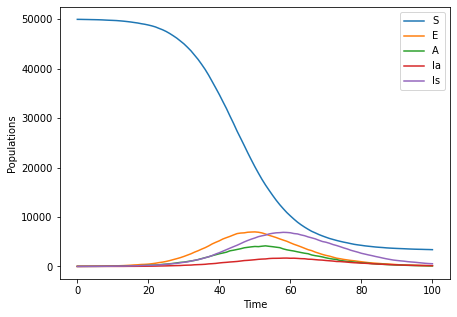

In [4]:
# plot the stochastic solution 
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(np.sum (data_array[:, 0*M:1*M],axis=-1), label='S')
ax.plot(np.sum (data_array[:, 1*M:2*M],axis=-1), label='E')
ax.plot(np.sum (data_array[:, 2*M:3*M],axis=-1), label='A')
ax.plot(np.sum (data_array[:, 3*M:4*M],axis=-1), label='Ia')
ax.plot(np.sum (data_array[:, 4*M:5*M],axis=-1), label='Is')
ax.set_xlabel('Time')
ax.set_ylabel('Populations')
ax.legend()
plt.show(fig)
plt.close(fig)


# Infer parameters based on part of the trajectory

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x[:,:8*M]/N)[:Nf_inference]
steps = 101 # number internal integration steps taken

# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

In [6]:
# take a guess 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 

alpha_g = 0.3
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.1
beta_std = 0.1 
beta_bounds = (eps, 1)

gIa_g = 0.2
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.2
gIs_std = 0.1 
gIs_bounds = (eps, 1)

gE_g = 0.4
gE_std = 0.1 
gE_bounds = (eps, 1)

gA_g = 0.5
gA_std = 0.1 
gA_bounds = (eps, 1)


guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std])
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, gA_bounds])

start_time = time.time() 
params = estimator.inference(guess, stds, x, Tf_inference, Nf_inference, contactMatrix, beta_rescale=5,
                                  bounds=bounds, global_max_iter=20,
                                  eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=964746, Thu May  7 21:31:08 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.113898885246332e+03 1.0e+00 1.06e+00  1e-01  4e-01 0:17.7
    2     32 -3.346676897004829e+03 1.5e+00 1.26e+00  1e-01  5e-01 0:33.2
    3     48 -4.124939353433694e+03 2.0e+00 1.35e+00  1e-01  5e-01 0:47.9
    4     64 -3.603569312629078e+03 2.2e+00 1.29e+00  1e-01  4e-01 1:02.0
    5     80 -2.651292229524338e+03 2.5e+00 1.44e+00  1e-01  4e-01 1:15.3
    6     96 -3.405046550079854e+03 2.8e+00 1.35e+00  1e-01  4e-01 1:27.7
    7    112 -3.621381182791606e+03 2.8e+00 1.35e+00  1e-01  4e-01 1:38.7
    8    128 -2.165848346940843e+03 2.7e+00 1.18e+00  1e-01  3e-01 1:49.6
    9    144 -2.610998479222132e+03 3.1e+00 1.27e+00  1e-01  3e-01 2:08.8
   10    160 -3.318656810461851e+03 3.7e+00 1.28e+00  1e-01  3e-01 2:24.6
   11    176 -2.485642144415495e+03 3.9e+00 1.25e+00  1e-01  3e-0

In [7]:
hessian = estimator.hessian(params,guess, stds,x,Tf_inference,Nf_inference,contactMatrix)
cov = np.linalg.inv(hessian)
#cov

# Compare forecast based on inferred parameters to full trajectory

In [8]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'gE':params[4],'gA':params[5],
                 'fsa':fsa, 'fh':fh, 
              'gIh':gIh,'gIc':gIc,
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm,
             'cov':cov}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAI5R(parameters, M, Ni)

In [9]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[-1,:M]*N
E0_forecast = x[-1,M:2*M]*N
A0_forecast = x[-1,2*M:3*M]*N
Ia0_forecast = x[-1,3*M:4*M]*N
Is0_forecast = x[-1,4*M:5*M]*N
Ih0_forecast = x[-1,5*M:6*M]*N
Ic0_forecast = x[-1,6*M:7*M]*N
Im0_forecast = x[-1,7*M:   ]*N


# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, E0_forecast, A0_forecast,Ia0_forecast,
                                           Is0_forecast, Ih0_forecast,Ic0_forecast, Im0_forecast, 
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

Finished. Time needed for evaluation: 00:00:07


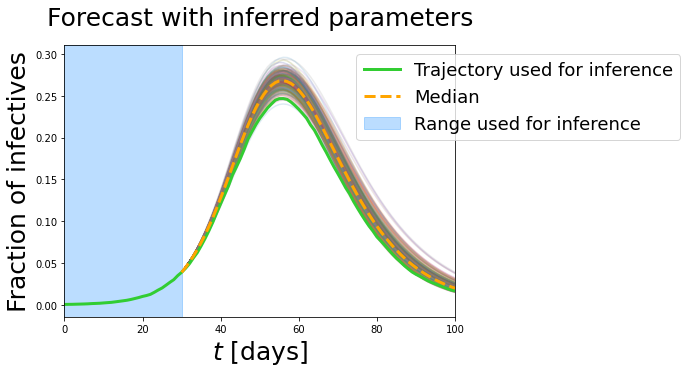

In [10]:
# Plot sum of A, Ia, Is populations

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.6,1),
          fontsize=18)
plt.show(fig)
#fig.savefig('inference_forecast.png',dpi=100,bbox_inches='tight')
plt.close(fig)